**CSI 4506 Introduction à l'intelligence artificielle** <br/>
*Devoir 2: apprentissage automatique*

# Identification

Nom: Youssef Chouay <br/>
Numéro d'étudiant : 300162426


# Exploration des données

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Charger le jeu de données et fournir un résumé de sa structure :

#### **Décrivez les attributs (colonnes), leurs types de données et la variable cible.**

In [40]:
dataset = pd.read_csv("https://raw.githubusercontent.com/turcotte/csi4106-f24/refs/heads/main/assignments-data/a2/diabetes_prediction_dataset.csv")
print(dataset.dtypes)
print(dataset.head())


gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155     

On remarque que le jeu de données contient 9 colonnes, dont 8 sont des attributs et 1 est la variable cible. Les attributs sont majoritairement de type numérique (`age`, `bmi`, `HbA1c_level`, `blood_glucose_level`) ou binaire (`hypertension`, `heart_disease`), avec quelques variables de type catégorique (`gender`, `smoking_history`). La variable cible `diabetes` est de type binaire (0 ou 1).

### 2. Analyse de la distribution des attributs :
#### **Examinez la distribution de chaque attribut à l'aide de visualisations appropriées telles que des histogrammes et des boxplots. Discutez des informations obtenues, y compris la présence de valeurs aberrantes.**

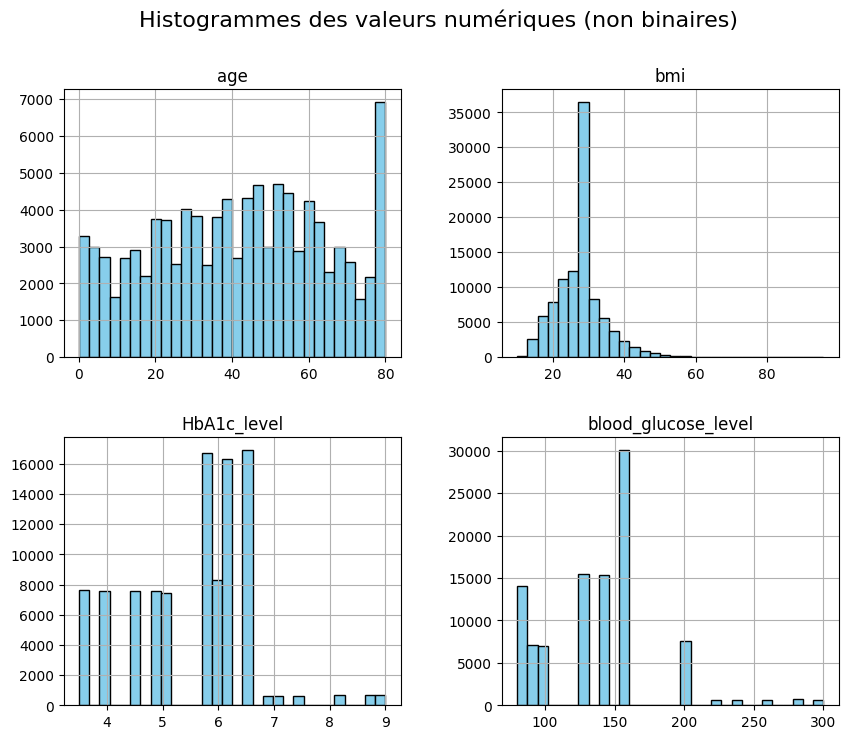

In [41]:
dataset_hist = dataset[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']]
dataset_hist.hist(bins=30, color='skyblue', edgecolor='black', figsize=(10, 8))
plt.suptitle('Histogrammes des valeurs numériques (non binaires)', fontsize=16)
plt.show()

<Axes: >

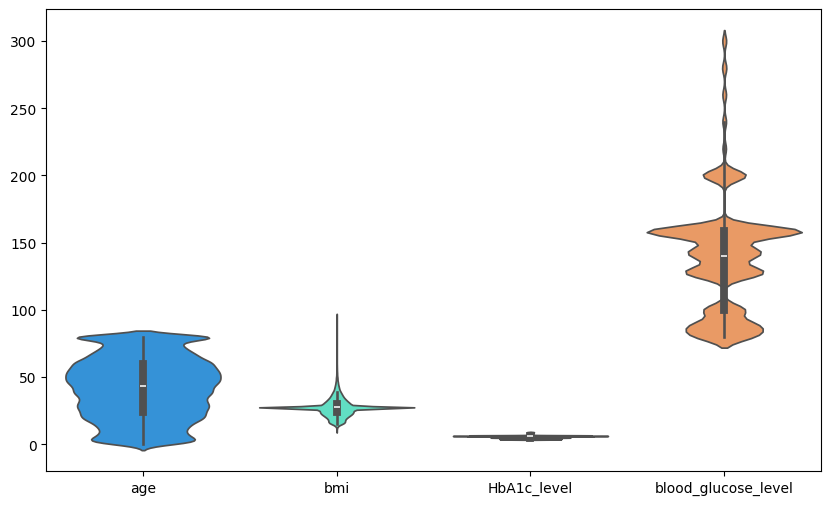

In [42]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=dataset_hist,palette='rainbow')

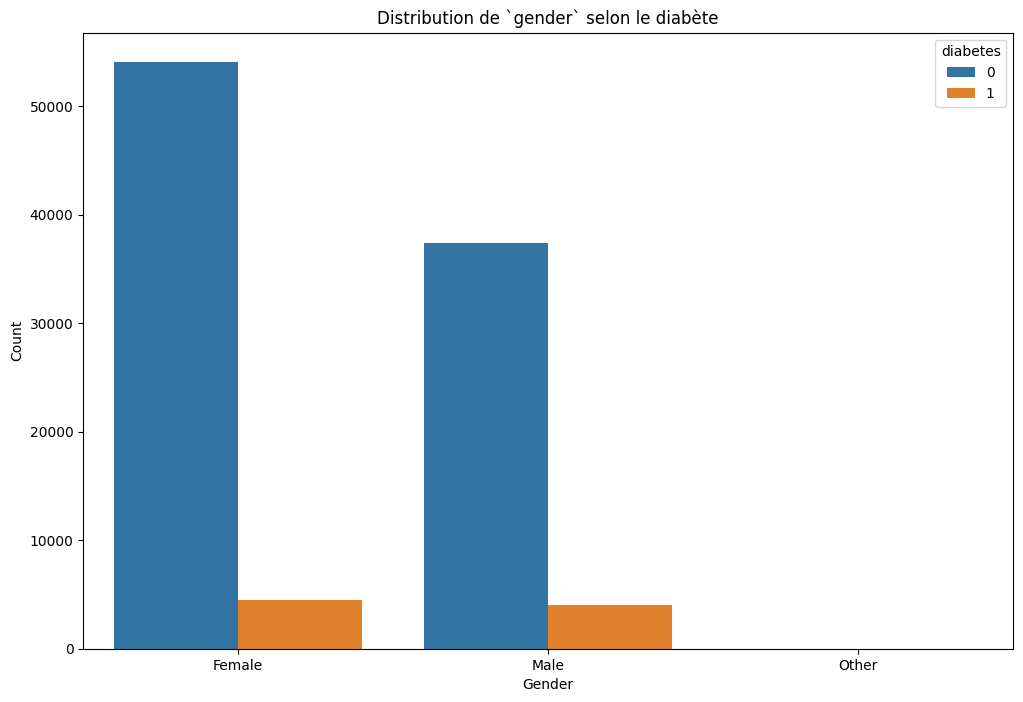

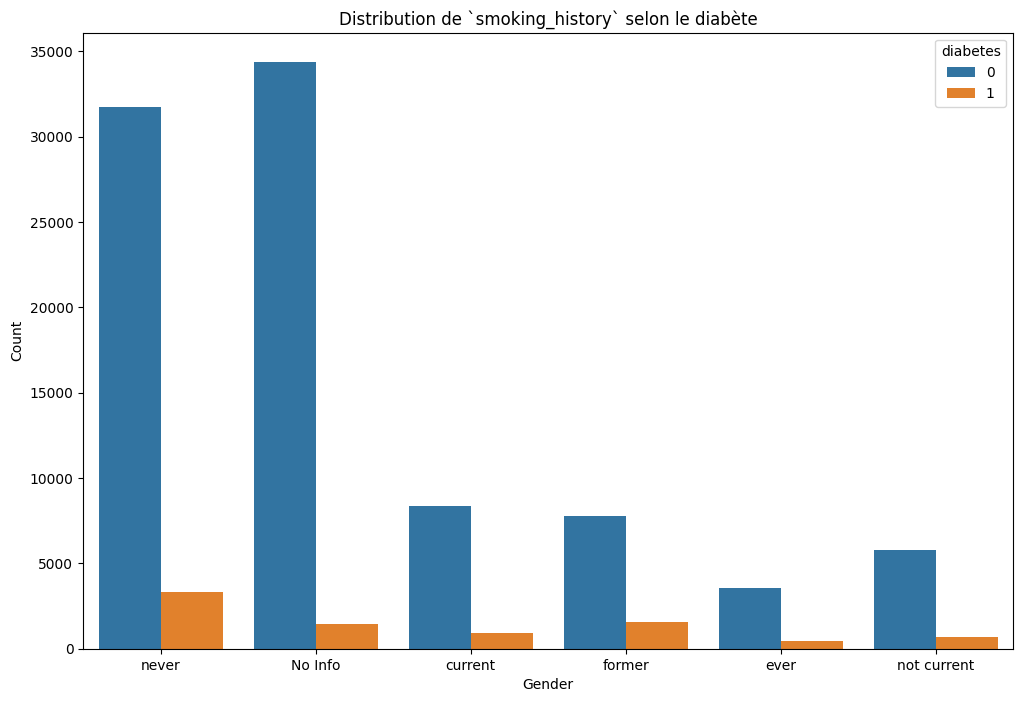

In [43]:
plt.figure(figsize=(12, 8))
sns.countplot(x='gender', hue='diabetes', data=dataset)
plt.title('Distribution de `gender` selon le diabète')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(12, 8))
sns.countplot(x='smoking_history', hue='diabetes', data=dataset)
plt.title('Distribution de `smoking_history` selon le diabète')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

In [44]:
def detect_outliers(df):
  outliers = pd.DataFrame(columns=df.columns)
  outlier_columns = []
  for column in df.columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_in_column = df[(df[column] < lower_bound) | (df[column] > upper_bound)].copy()
    outliers_in_column['Outlier_Column'] = column
    outliers = pd.concat([outliers, outliers_in_column])
  return outliers

In [45]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
outliers = detect_outliers(dataset_hist)
# outliers = outliers.drop_duplicates()
print("Nombre de valeurs aberrantes detectées :", len(outliers))
print("Pourcentage de valeurs aberrantes par rapport au dataset :", len(outliers) / len(numeric_dataset) * 100)
outliers_by_column = outliers['Outlier_Column'].value_counts()
print("Nombre de valeurs aberrantes par colonne :")
for column, count in outliers_by_column.items():
  print(f"{column} : {count}")

Nombre de valeurs aberrantes detectées : 10439
Pourcentage de valeurs aberrantes par rapport au dataset : 10.439
Nombre de valeurs aberrantes par colonne :
bmi : 7086
blood_glucose_level : 2038
HbA1c_level : 1315


On remarque que les attributs `age` et `bmi` sont distribués de manière relativement normale, avec quelques valeurs aberrantes. Les attributs `hypertension` et `heart_disease` sont binaires, donc leur distribution est plus simple.
Les attributs `HbA1c_level` et `blood_glucose_level` sont distribués de manière plus complexe, avec des valeurs aberrantes et une distribution asymétrique. Les attributs `gender` et `smoking_history` sont catégoriques, donc leur distribution est également simple.
Les valeurs aberrantes en général sont vraiment presentes (~ 10% des données) et peuvent affecter la performance du modèle.

### 3. Distribution de la variable cible :
#### **Analysez la distribution de la variable cible pour identifier les déséquilibres de classes. Utilisez des diagrammes en barres pour visualiser les fréquences des classes.**

diabetes
0    91500
1     8500
Name: count, dtype: int64


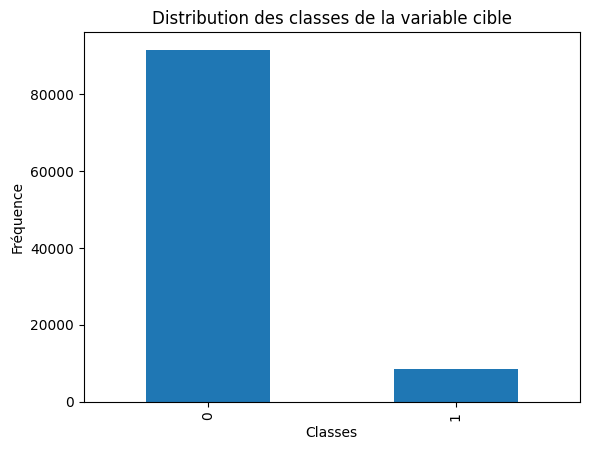

In [46]:
distribution = dataset['diabetes'].value_counts()
print(distribution)
distribution.plot(kind='bar')
plt.title('Distribution des classes de la variable cible')
plt.xlabel('Classes')
plt.ylabel('Fréquence')
plt.show()

On remarque une disparité entre les classes de la variable cible `diabetes`, avec une majorité de patients non diabétiques (classe 0) par rapport aux patients diabétiques (classe 1). Ce déséquilibre de classes peut affecter la performance du modèle, comme aussi, il pourrait refleter un biais dans les données qui provient de la vraie distribution des patients diabétiques dans la population.

### 4. Fractionnement des données :
#### **Divisez le jeu de données en ensembles d'entraînement (80 %) et de test (20 %) en utilisant la méthode du holdout.**
Assurez-vous que ce fractionnement intervient avant tout prétraitement afin d'éviter les fuites de données.

In [47]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)
print(f"Training set size: {len(train_set)}")
print(f"Testing set size: {len(test_set)}")

Training set size: 80000
Testing set size: 20000


# Prétraitement des données

### 5. Encodage des variables catégoriques :
#### **Encodez les variables catégoriques. Justifiez la méthode choisie.**

In [48]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

label_encoder = LabelEncoder()
# Encodage pour le jeu d'entraînement
train_set['gender'] = label_encoder.fit_transform(train_set['gender'])
# Encodage pour le jeu de test
test_set['gender'] = label_encoder.transform(test_set['gender'])
# --------------------
onehot_encoder = OneHotEncoder(sparse_output=False)
# Encodage pour le jeu d'entraînement
smoking_history_encoded = onehot_encoder.fit_transform(train_set[['smoking_history']])
smoking_history_encoded_df = pd.DataFrame(smoking_history_encoded, columns=onehot_encoder.get_feature_names_out(['smoking_history']))
train_set = pd.concat([train_set.reset_index(drop=True), smoking_history_encoded_df.reset_index(drop=True)], axis=1)
train_set.drop('smoking_history', axis=1, inplace=True)
# Encodage pour le jeu de test
smoking_history_encoded = onehot_encoder.transform(test_set[['smoking_history']])
smoking_history_encoded_df = pd.DataFrame(smoking_history_encoded, columns=onehot_encoder.get_feature_names_out(['smoking_history']))
test_set = pd.concat([test_set.reset_index(drop=True), smoking_history_encoded_df.reset_index(drop=True)], axis=1)
test_set.drop('smoking_history', axis=1, inplace=True)


Pour l'encodage des variables categoriques, j'ai choisi d'utiliser l'encodage one-hot pour la variable `smoking_history`, car il est plus adapté pour les variables catégoriques avec plus de deux catégories. Cela permet de transformer les variables catégoriques en plusieurs variables binaires, ce qui facilite l'entrainement du modèle. Quant à la variable `gender`, j'ai choisi d'utiliser un encodage binaire (0 ou 1) car elle contient seulement deux catégories.

### 6. Normalisation/Standardisation des attributs numériques :
#### **Normalisez ou standardisez les attributs numériques si nécessaire. Décrivez la technique utilisée (par exemple, le scaling Min-Max, StandardScaler) et expliquez pourquoi elle est appropriée pour ce jeu de données.**
Assurez-vous que cette technique est appliquée uniquement aux données d'entraînement, avec la même transformation appliquée ensuite aux données de test sans nouvel ajustement.

In [49]:
# Linear scaling for `age`
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_set['age'] = scaler.fit_transform(train_set[['age']])
test_set['age'] = scaler.transform(test_set[['age']])
# Standard scaling for `bmi`
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_set['bmi'] = scaler.fit_transform(train_set[['bmi']])
test_set['bmi'] = scaler.transform(test_set[['bmi']])
# Standard scaling for `HbA1c_level`
scaler = StandardScaler()
train_set['HbA1c_level'] = scaler.fit_transform(train_set[['HbA1c_level']])
test_set['HbA1c_level'] = scaler.transform(test_set[['HbA1c_level']])
# Robust scaling for `blood_glucose_level`
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
train_set['blood_glucose_level'] = scaler.fit_transform(train_set[['blood_glucose_level']])
test_set['blood_glucose_level'] = scaler.transform(test_set[['blood_glucose_level']])

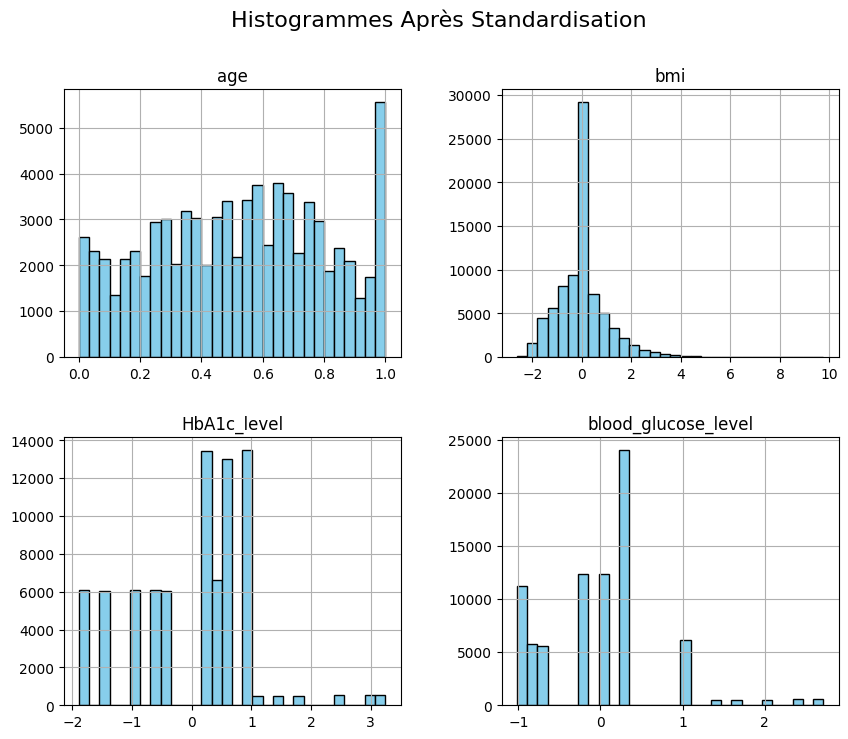

In [50]:
train_set_hist = train_set[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']]
train_set_hist.hist(bins=30, color='skyblue', edgecolor='black', figsize=(10, 8))
plt.suptitle('Histogrammes Après Standardisation', fontsize=16)
plt.show()

Pour normaliser les attributs numériques, j'ai utilisé le scaling Min-Max pour la variable `age`, cette technique est appropriée pour cette variable car elle est plutôt distribuée de manière équivalente. Pour les variables `bmi` et `HbA1c_level`, j'ai utilisé le StandardScaler, car ces variables sont distribuées de manière plus normale. Pour la variable `blood_glucose_level`, j'ai utilisé le RobustScaler, car elle contient plus de valeurs aberrantes.

## Développement et évaluation des modèles

7. **Développement des modèles** :

    - Implémentez les modèles d'apprentissage automatique abordés en classe : arbres de décision, K-Nearest Neighbors (KNN) et régression logistique. Utilisez les paramètres par défaut de scikit-learn comme base pour entraîner chaque modèle.

In [51]:
# Cellule de code

8. **Évaluation des modèles** :

    - Utilisez la validation croisée pour évaluer chaque modèle, en justifiant votre choix du nombre de plis.

    - Évaluez les modèles à l'aide de métriques telles que la précision, le rappel et le score F1.

In [52]:
# Cellule de code

## Optimisation des hyperparamètres

9. **Exploration et évaluation des performances :**

    - Étudiez l'impact de la variation des valeurs des hyperparamètres sur les performances de chaque modèle.

    - Concentrez-vous sur les hyperparamètres pertinents suivants pour chaque modèle :

        - [DecisionTreeClassifier](https://scikit-learn.org/dev/modules/generated/sklearn.tree.DecisionTreeClassifier.html) : `criterion` et `max_depth`.
  
        - [LogisticRegression](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html) : `penalty`, `max_iter`, et `tol`.
  
        - [KNeighborsClassifier](https://scikit-learn.org/dev/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) : `n_neighbors` et `weights`.

    - Employez une stratégie de recherche en grille ou utilisez les méthodes intégrées de scikit-learn pour évaluer exhaustivement toutes les combinaisons des valeurs d'hyperparamètres. La validation croisée doit être utilisée pour évaluer chaque combinaison.

    - Quantifiez les performances de chaque configuration d'hyperparamètres en utilisant des métriques telles que la précision, le rappel et le score F1.

    - Affichez les résultats dans un format tabulaire ou graphique (par exemple, graphiques en ligne, diagrammes en barres) pour démontrer efficacement l'influence des variations des hyperparamètres sur les performances du modèle.

    - Spécifiez les valeurs par défaut de chaque hyperparamètre testé.

    - Analysez les résultats et offrez des perspectives sur les configurations d'hyperparamètres ayant obtenu les meilleures performances pour chaque modèle.

In [53]:
# Cellule de code

## Analyse des résultats

10. **Comparaison des modèles** :

    - Comparez les résultats obtenus pour chaque modèle.

    - Discutez des différences observées dans les performances des modèles et fournissez des explications potentielles. Considérez des aspects tels que la complexité des modèles, le déséquilibre des données, le surapprentissage et l'impact du réglage des paramètres sur les résultats globaux.

    - Fournissez des recommandations sur le(s) modèle(s) à choisir pour cette tâche et justifiez vos choix en fonction des résultats de l'analyse.

    - Entraînez le(s) modèle(s) recommandé(s) en utilisant les valeurs optimales des paramètres identifiés lors de l'optimisation des paramètres. Appliquez ensuite le modèle entraîné aux données de test. Documentez vos observations de manière détaillée. Évaluez spécifiquement si les résultats dérivés de la validation croisée sont cohérents avec ceux obtenus sur le jeu de test.

In [54]:
# Cellule de code